In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import os

# Configurar matplotlib para VSCode
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Paths absolutos
BASE_DIR = "/Users/diego/Documents/tesis_standalone/tesis_unet_2"
MODEL_PATHS = {
    'last12': f"{BASE_DIR}/logs/last12/test_results.h5",
    'unet3': f"{BASE_DIR}/logs/unet3/test_results.h5",
    'unet4': f"{BASE_DIR}/logs/unet4/test_results.h5"
}

In [18]:
def calculate_corrected_metrics(predictions, targets, threshold=0.1):
    """
    Calcula métricas corregidas con datos en escala correcta (mm/h)
    
    Args:
        predictions: Predicciones en mm/h
        targets: Targets en mm/h  
        threshold: Umbral de precipitación en mm/h
    """
    # Convertir valores negativos a 0 (no puede haber precipitación negativa)
    predictions = np.maximum(predictions, 0)
    targets = np.maximum(targets, 0)
    
    # Aplanar arrays para cálculos
    pred_flat = predictions.flatten()
    target_flat = targets.flatten()
    
    # MSE
    mse = np.mean((pred_flat - target_flat) ** 2)
    
    # Métricas categóricas
    pred_binary = (pred_flat > threshold).astype(int)
    target_binary = (target_flat > threshold).astype(int)
    
    # Tabla de contingencia
    tp = np.sum(pred_binary * target_binary)
    fp = np.sum(pred_binary * (1 - target_binary))
    fn = np.sum((1 - pred_binary) * target_binary)
    tn = np.sum((1 - pred_binary) * (1 - target_binary))
    
    # Evitar división por cero
    epsilon = 1e-8
    
    # CSI (Critical Success Index)
    csi = tp / (tp + fp + fn + epsilon)
    
    # FAR (False Alarm Rate)
    far = fp / (tp + fp + epsilon)
    
    # HSS (Heidke Skill Score)
    hss_num = 2 * (tp * tn - fp * fn)
    hss_den = (tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)
    hss = hss_num / (hss_den + epsilon)
    
    return {
        'mse': mse,
        'csi': csi,
        'far': far,
        'hss': hss,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    }

def load_and_recalculate_metrics(h5_path, threshold=0.1):
    """Carga datos y recalcula métricas correctamente"""
    with h5py.File(h5_path, 'r') as f:
        # Cargar datos con corrección de escala
        inputs_raw = f['inputs'][:]
        targets_raw = f['targets'][:]
        predictions_raw = f['predictions'][:]
        
        # Detectar si necesitan escalamiento
        inputs_max = inputs_raw.max()
        targets_max = targets_raw.max()
        
        # Escalar a mm/h si están en rango [0,1]
        scale_factor = 100.0 if inputs_max <= 1.1 else 1.0
        
        inputs = inputs_raw * scale_factor
        targets = targets_raw * scale_factor
        predictions = predictions_raw  # Las predicciones ya están en escala correcta
        
        # Convertir valores negativos a 0 (no puede haber precipitación negativa)
        inputs = np.maximum(inputs, 0)
        targets = np.maximum(targets, 0)
        predictions = np.maximum(predictions, 0)
        
        # Recalcular métricas
        corrected_metrics = calculate_corrected_metrics(predictions, targets, threshold)
        
        # Métricas originales (incorrectas)
        original_metrics = {
            'mse': f.attrs['metric_mse'],
            'csi': f.attrs['metric_csi'],
            'far': f.attrs['metric_far'],
            'hss': f.attrs['metric_hss']
        }
        
        data = {
            'inputs': inputs,
            'targets': targets,
            'predictions': predictions,
            'metrics_original': original_metrics,
            'metrics_corrected': corrected_metrics,
            'model_type': f.attrs['model_type'],
            'scale_factor_applied': scale_factor
        }
        
        print(f"✅ {data['model_type']} - Secuencias: {inputs.shape[0]}")
        print(f"   Factor de escala aplicado: {scale_factor}x")
        print(f"   Rangos - Inputs: {inputs.min():.1f}-{inputs.max():.1f}, Preds: {predictions.min():.1f}-{predictions.max():.1f}")
        print(f"   MSE original: {original_metrics['mse']:.4f} → corregida: {corrected_metrics['mse']:.4f}")
        print(f"   CSI original: {original_metrics['csi']:.4f} → corregida: {corrected_metrics['csi']:.4f}")
        
        return data

# Recargar todos los modelos con métricas corregidas
print("🔄 RECALCULANDO MÉTRICAS CON ESCALAS CORRECTAS")
print("=" * 60)

results_corrected = {}
for name, path in MODEL_PATHS.items():
    if os.path.exists(path):
        print(f"\nProcesando {name}...")
        results_corrected[name] = load_and_recalculate_metrics(path, threshold=0.1)

print("\n" + "=" * 60)
print("✅ RECÁLCULO COMPLETADO")

🔄 RECALCULANDO MÉTRICAS CON ESCALAS CORRECTAS

Procesando last12...
✅ last12 - Secuencias: 29
   Factor de escala aplicado: 100.0x
   Rangos - Inputs: 0.0-100.0, Preds: 0.0-100.0
   MSE original: 0.0670 → corregida: 674.4679
   CSI original: 0.0136 → corregida: 0.3962

Procesando unet3...
✅ unet3 - Secuencias: 29
   Factor de escala aplicado: 100.0x
   Rangos - Inputs: 0.0-100.0, Preds: 0.0-70.7
   MSE original: 0.0090 → corregida: 89.3403
   CSI original: 0.1929 → corregida: 0.1877

Procesando unet4...
✅ unet4 - Secuencias: 29
   Factor de escala aplicado: 100.0x
   Rangos - Inputs: 0.0-100.0, Preds: 0.0-52.1
   MSE original: 0.0089 → corregida: 87.2968
   CSI original: 0.1946 → corregida: 0.1962

✅ RECÁLCULO COMPLETADO


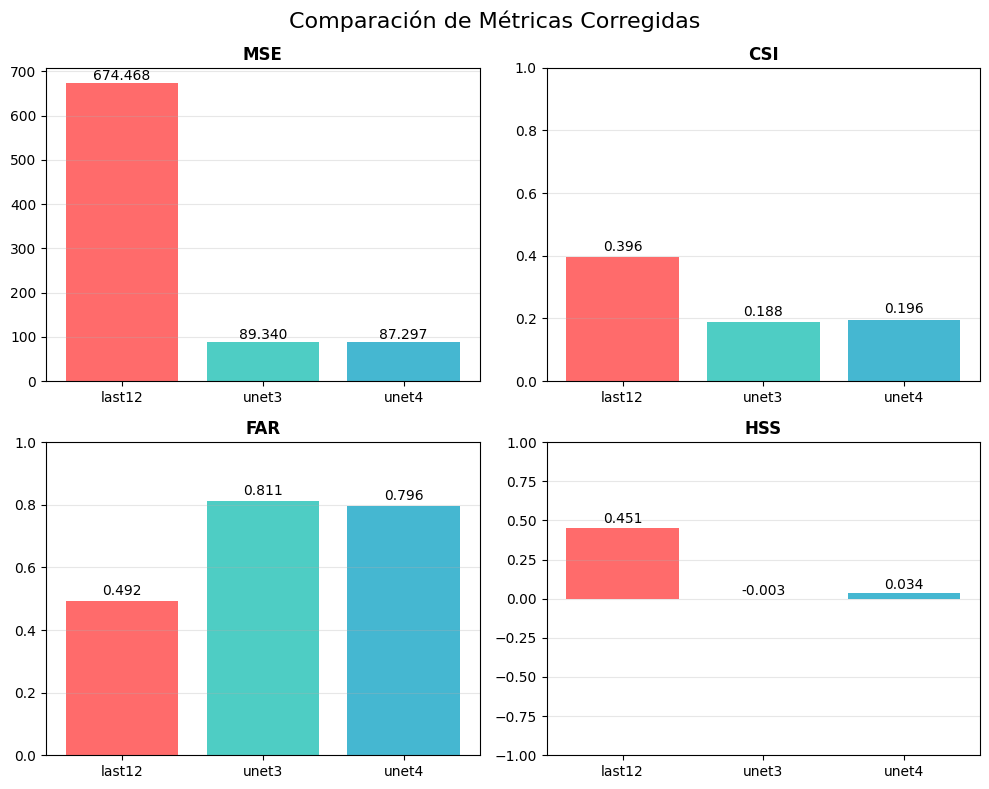

In [24]:
# Comparación de métricas con rangos fijos
metrics = ['mse', 'csi', 'far', 'hss']
models = list(results_corrected.keys())

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

# Definir rangos para cada métrica
metric_ranges = {
    'mse': None,     # MSE usa rango automático
    'csi': (0, 1),   # CSI: 0 a 1
    'far': (0, 1),   # FAR: 0 a 1  
    'hss': (-1, 1)   # HSS: -1 a 1
}

for idx, metric in enumerate(metrics):
    values = [results_corrected[m]['metrics_corrected'][metric] for m in models]
    bars = axes[idx].bar(models, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    
    # Valores en las barras
    for bar, val in zip(bars, values):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{val:.3f}', ha='center', va='bottom')
    
    axes[idx].set_title(metric.upper(), fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Fijar rangos del eje Y según la métrica
    if metric_ranges[metric] is not None:
        axes[idx].set_ylim(metric_ranges[metric])

plt.suptitle('Comparación de Métricas Corregidas', fontsize=16)
plt.tight_layout()
plt.show()

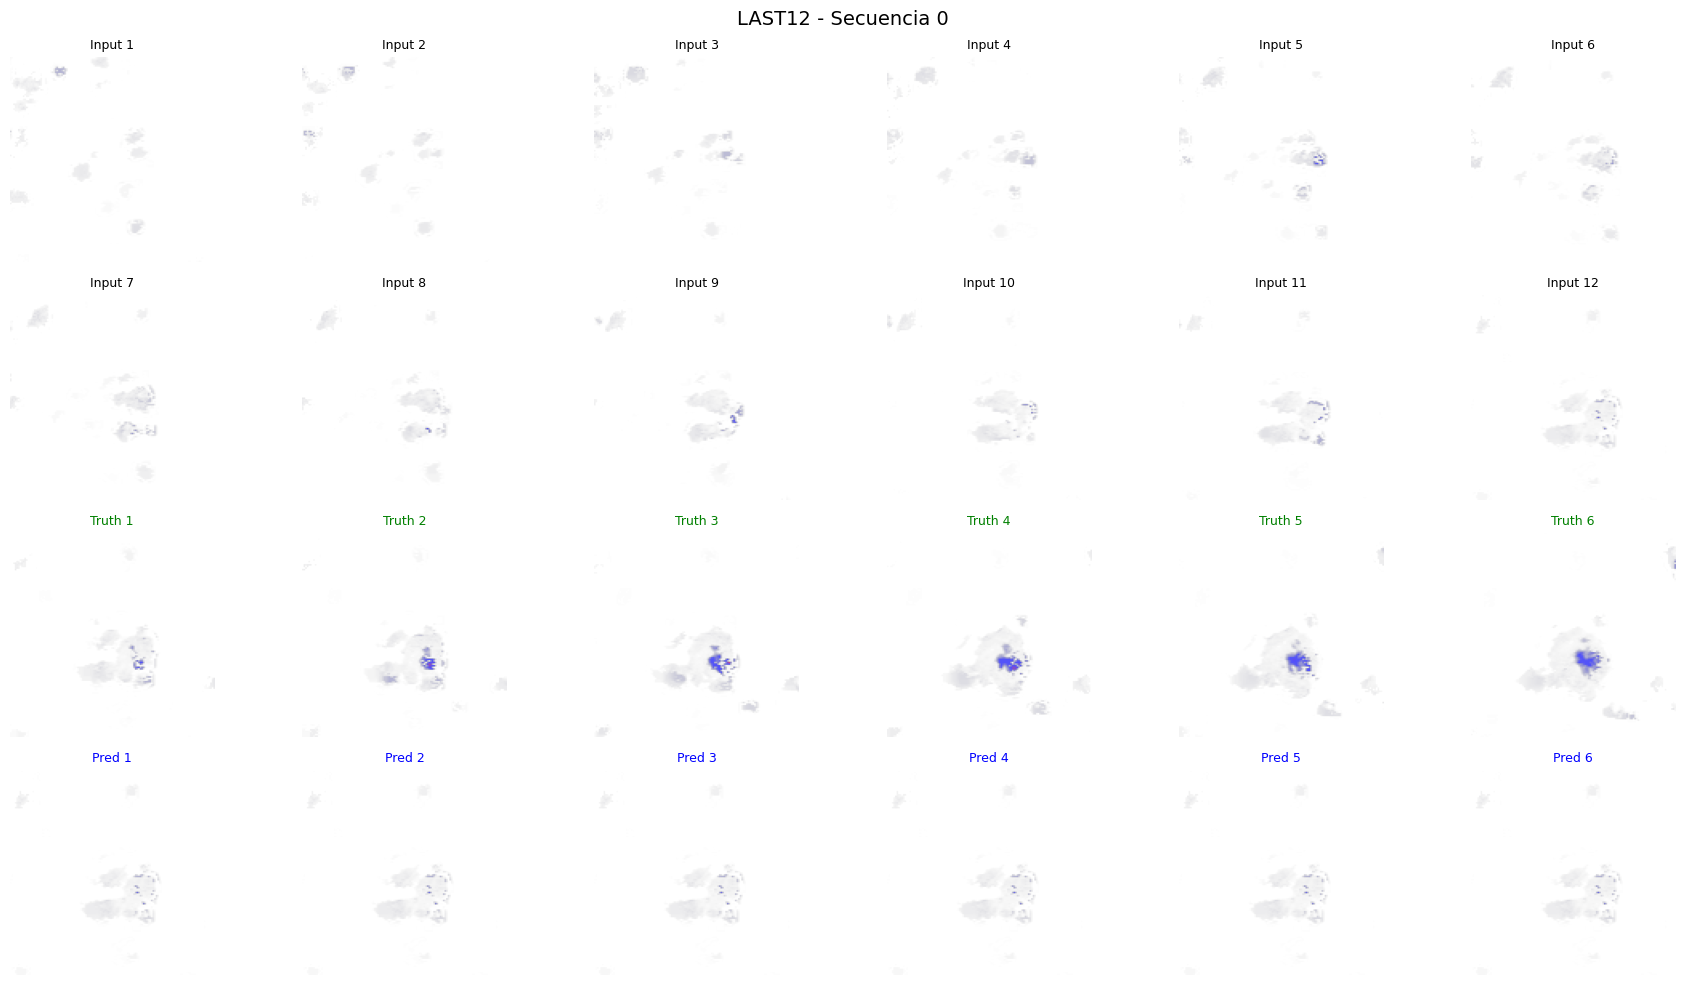

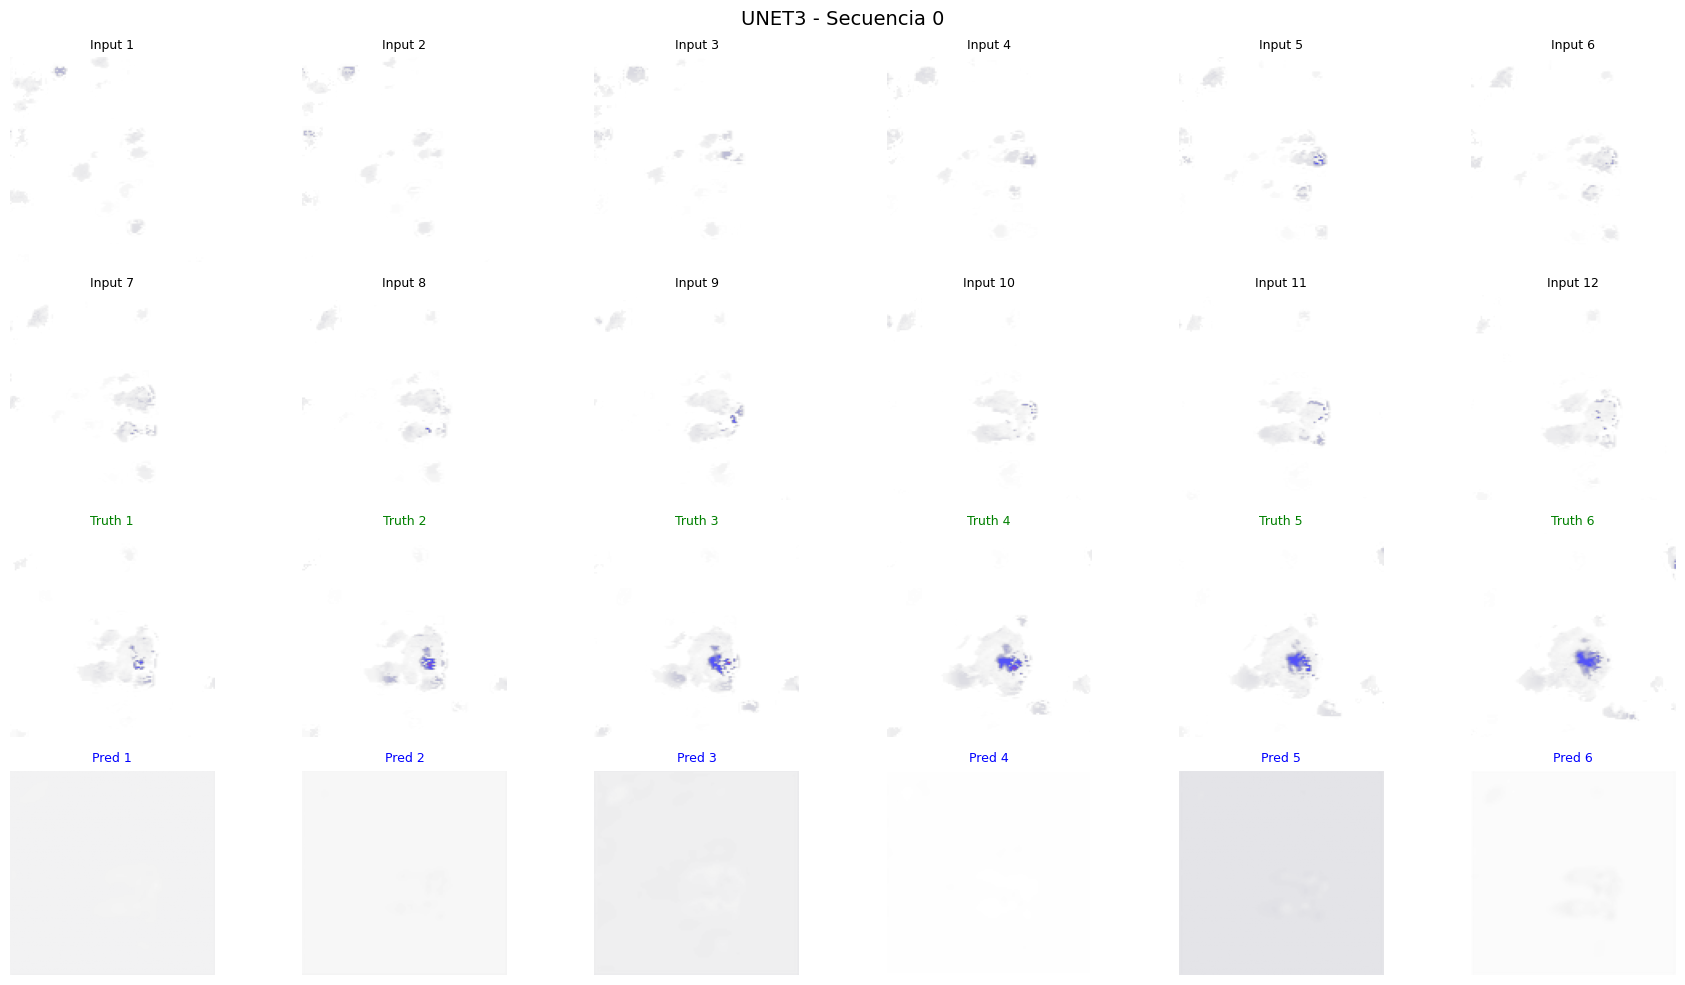

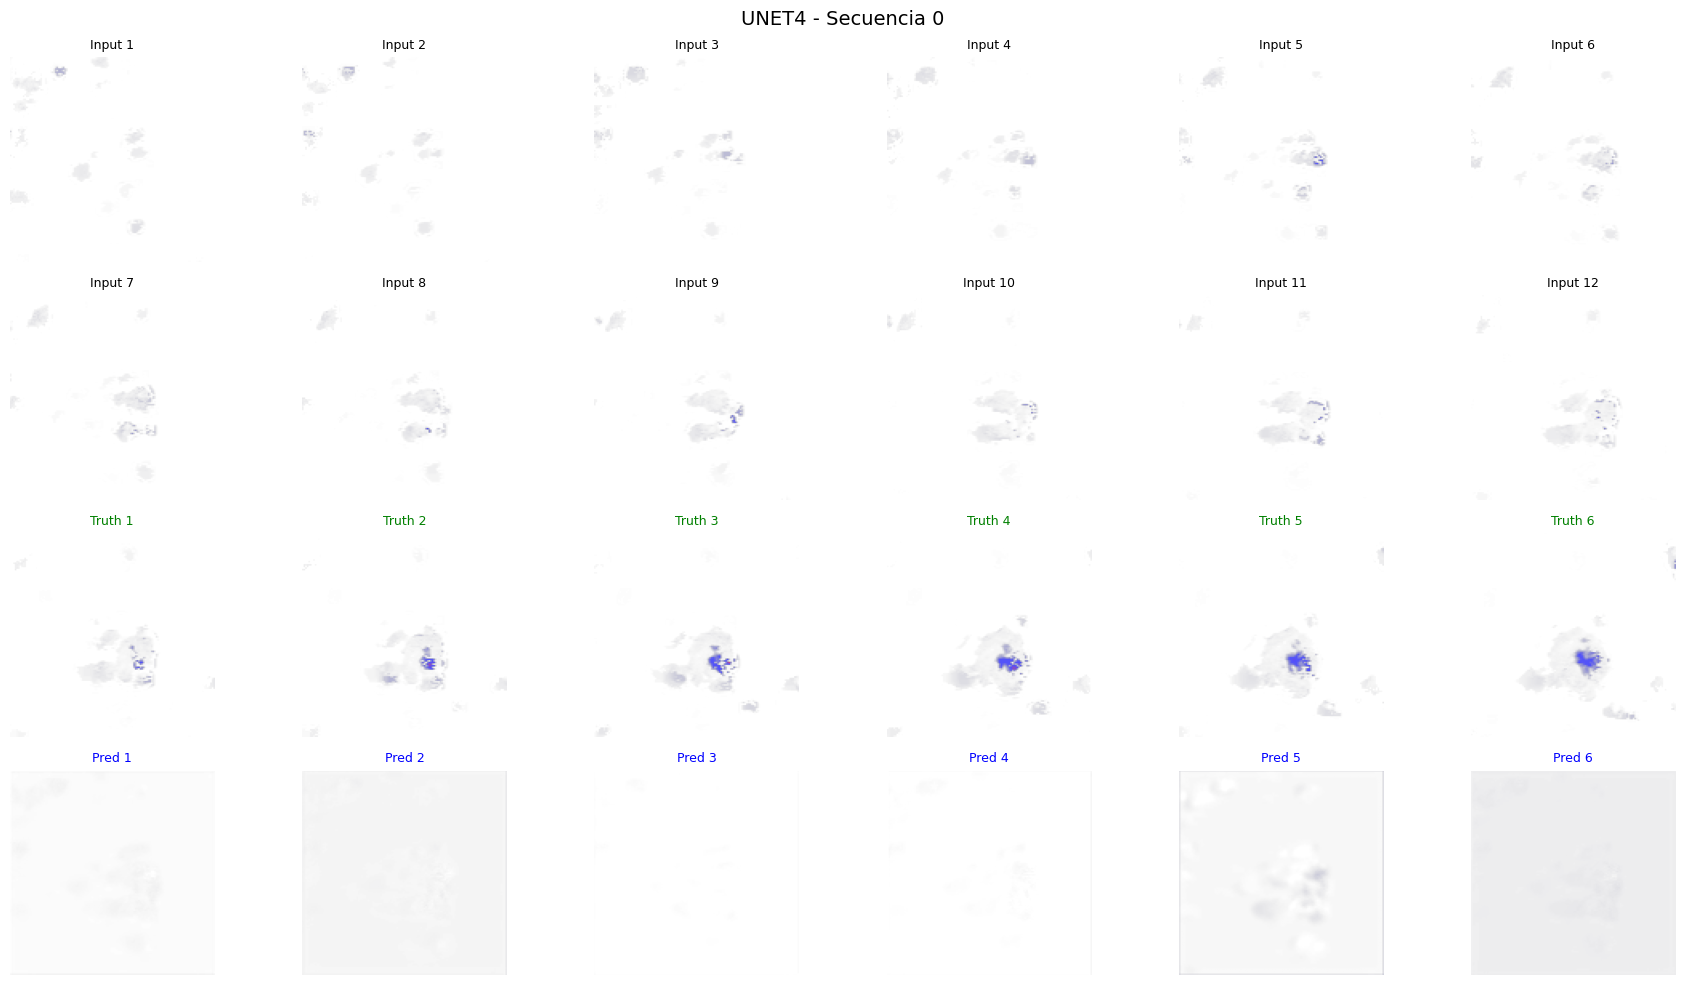

In [21]:
def show_prediction(model_name, seq_idx=0):
    """Muestra inputs, targets y predicciones para una secuencia"""
    data = results_corrected[model_name]
    
    # Datos
    inputs = data['inputs'][seq_idx]
    targets = data['targets'][seq_idx]
    preds = data['predictions'][seq_idx]
    
    # Crear figura
    fig = plt.figure(figsize=(18, 10))
    
    # Colormap personalizado
    colors = [(0, 0, 0, 0), (0, 0, 1, 0.7), (1, 0, 0, 0.7)]
    cmap = mcolors.LinearSegmentedColormap.from_list("rain", list(zip([0, 0.5, 1], colors)))
    
    # Inputs (2 filas de 6)
    for i in range(12):
        plt.subplot(4, 6, i+1)
        plt.imshow(inputs[i]*1, cmap=cmap, vmin=0, vmax=100)
        plt.title(f'Input {i+1}', fontsize=9)
        plt.axis('off')
    
    # Ground truth
    for i in range(6):
        plt.subplot(4, 6, 13+i)
        plt.imshow(targets[i]*1, cmap=cmap, vmin=0, vmax=100)
        plt.title(f'Truth {i+1}', fontsize=9, color='green')
        plt.axis('off')
    
    # Predicciones
    for i in range(6):
        plt.subplot(4, 6, 19+i)
        plt.imshow(preds[i], cmap=cmap, vmin=0, vmax=100)
        plt.title(f'Pred {i+1}', fontsize=9, color='blue')
        plt.axis('off')
    
    plt.suptitle(f'{model_name.upper()} - Secuencia {seq_idx}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualizar una secuencia de cada modelo
for model in results_corrected.keys():
    show_prediction(model, seq_idx=0)

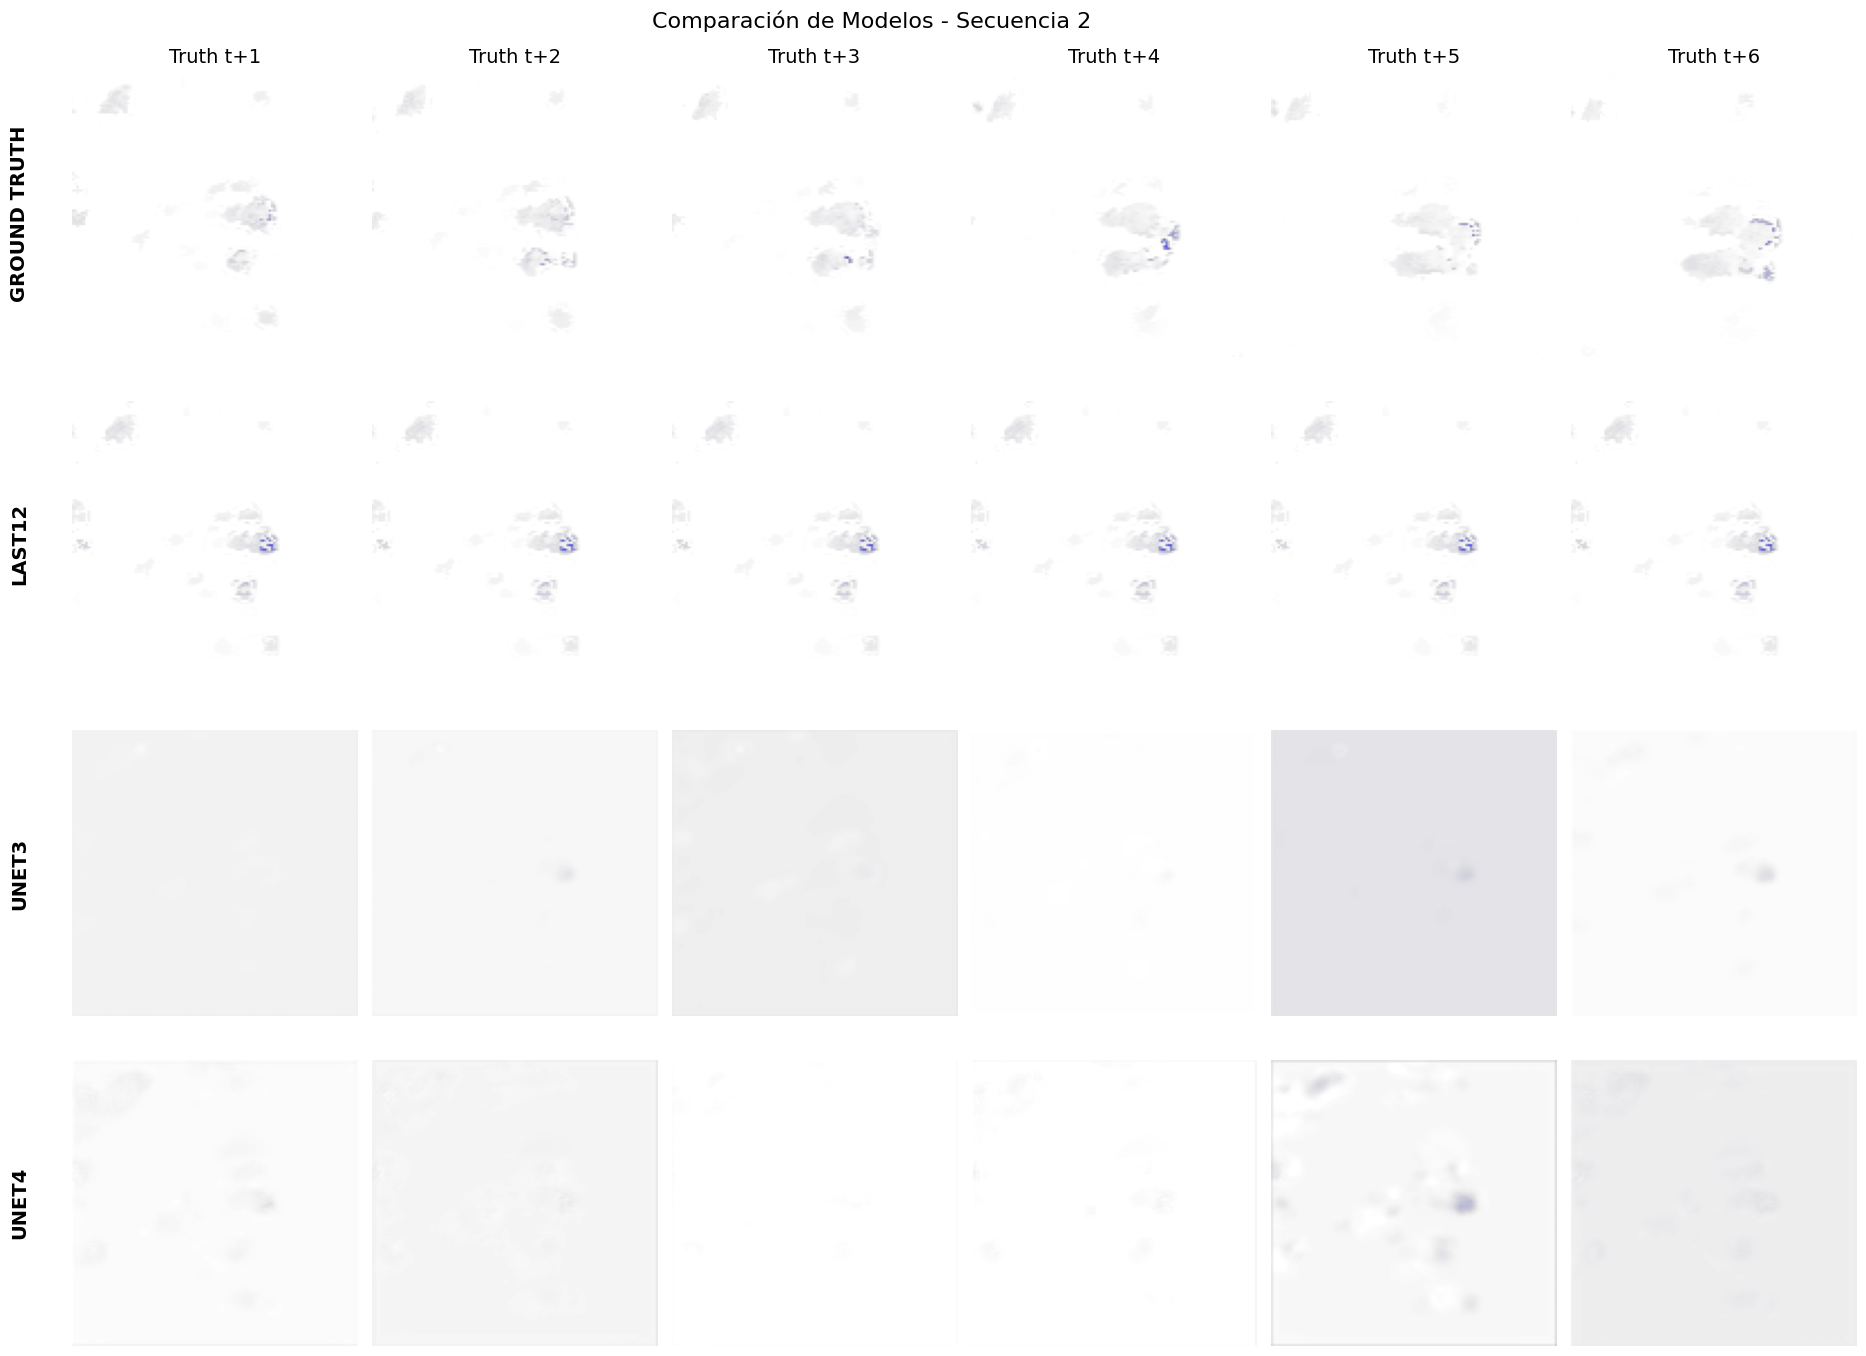

In [22]:
def compare_models(seq_idx=0, results = results_corrected):
    """Compara predicciones de todos los modelos"""
    fig, axes = plt.subplots(4, 6, figsize=(20, 14))  # Aumentar el tamaño
    
    # Colormap
    colors = [(0, 0, 0, 0), (0, 0, 1, 0.7), (1, 0, 0, 0.7)]
    cmap = mcolors.LinearSegmentedColormap.from_list("rain", list(zip([0, 0.5, 1], colors)))
    
    # Ground truth (primera fila)
    targets = results[list(results.keys())[0]]['targets'][seq_idx]
    for i in range(6):
        axes[0, i].imshow(targets[i], cmap=cmap, vmin=0, vmax=100)
        axes[0, i].set_title(f'Truth t+{i+1}', fontsize=14)
        axes[0, i].axis('off')
    
    # Etiqueta para la fila Ground Truth
    axes[0, 0].text(-0.15, 0.5, 'GROUND TRUTH', transform=axes[0, 0].transAxes, 
                    fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
    
    # Predicciones de cada modelo
    row = 1
    model_names = ['last12', 'unet3', 'unet4']
    for model_name in model_names:
        if model_name in results:
            preds = results[model_name]['predictions'][seq_idx]
            for i in range(6):
                axes[row, i].imshow(preds[i], cmap=cmap, vmin=0, vmax=100)
                axes[row, i].axis('off')
            
            # Agregar etiqueta del modelo en el primer subplot de la fila
            axes[row, 0].text(-0.15, 0.5, model_name.upper(), transform=axes[row, 0].transAxes, 
                             fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
            row += 1
    
    plt.suptitle(f'Comparación de Modelos - Secuencia {seq_idx}', fontsize=16)
    plt.tight_layout()
    
    # Ajustar el layout para que las etiquetas no se corten
    plt.subplots_adjust(left=0.1)
    plt.show()

# Comparar modelos
compare_models(2)

📊 RESUMEN DE RESULTADOS

LAST12:
  Secuencias totales: 29
  Métricas corregidas:
    - MSE: 674.4679
    - CSI: 0.3962
    - FAR: 0.4917
    - HSS: 0.4514
  MAE global: 7.82
  Max error: 100.00
  Tabla de contingencia:
    TP: 347,271 (12.2%)
    FP: 335,985 (11.8%)
    FN: 193,201 (6.8%)
    TN: 1,974,359 (69.3%)

UNET3:
  Secuencias totales: 29
  Métricas corregidas:
    - MSE: 89.3403
    - CSI: 0.1877
    - FAR: 0.8115
    - HSS: -0.0027
  MAE global: 5.88
  Max error: 98.39
  Tabla de contingencia:
    TP: 528,989 (18.6%)
    FP: 2,277,276 (79.9%)
    FN: 11,483 (0.4%)
    TN: 33,068 (1.2%)

UNET4:
  Secuencias totales: 29
  Métricas corregidas:
    - MSE: 87.2968
    - CSI: 0.1962
    - FAR: 0.7955
    - HSS: 0.0344
  MAE global: 4.86
  Max error: 98.76
  Tabla de contingencia:
    TP: 447,694 (15.7%)
    FP: 1,741,629 (61.1%)
    FN: 92,778 (3.3%)
    TN: 568,715 (19.9%)


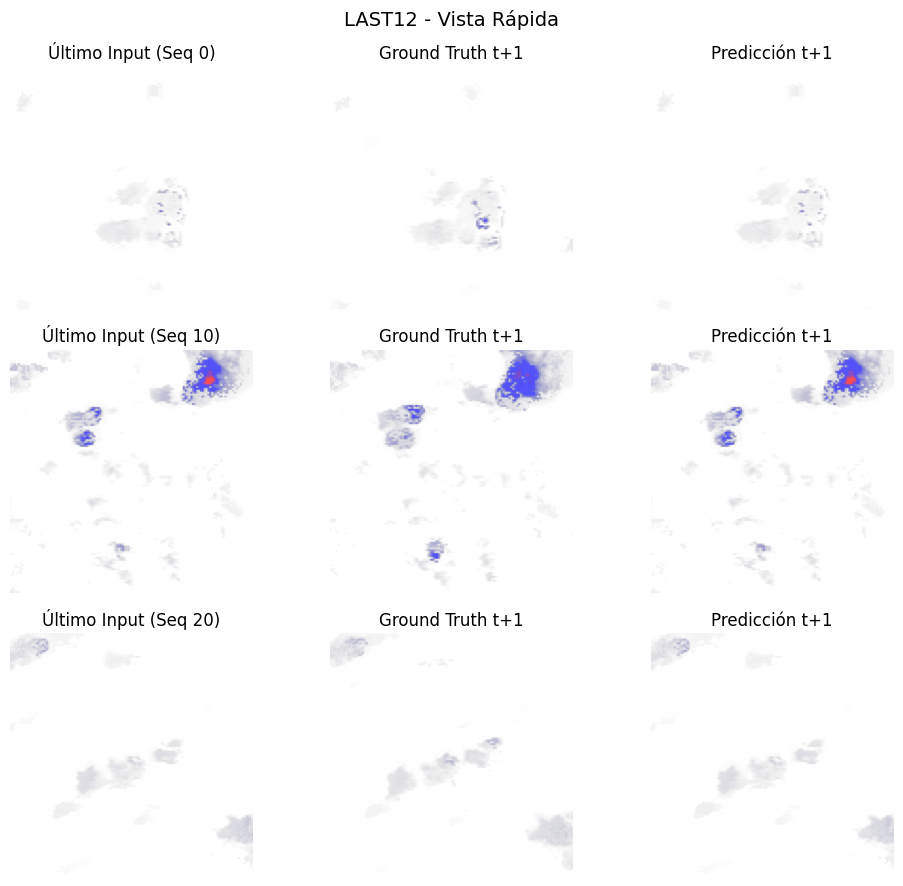

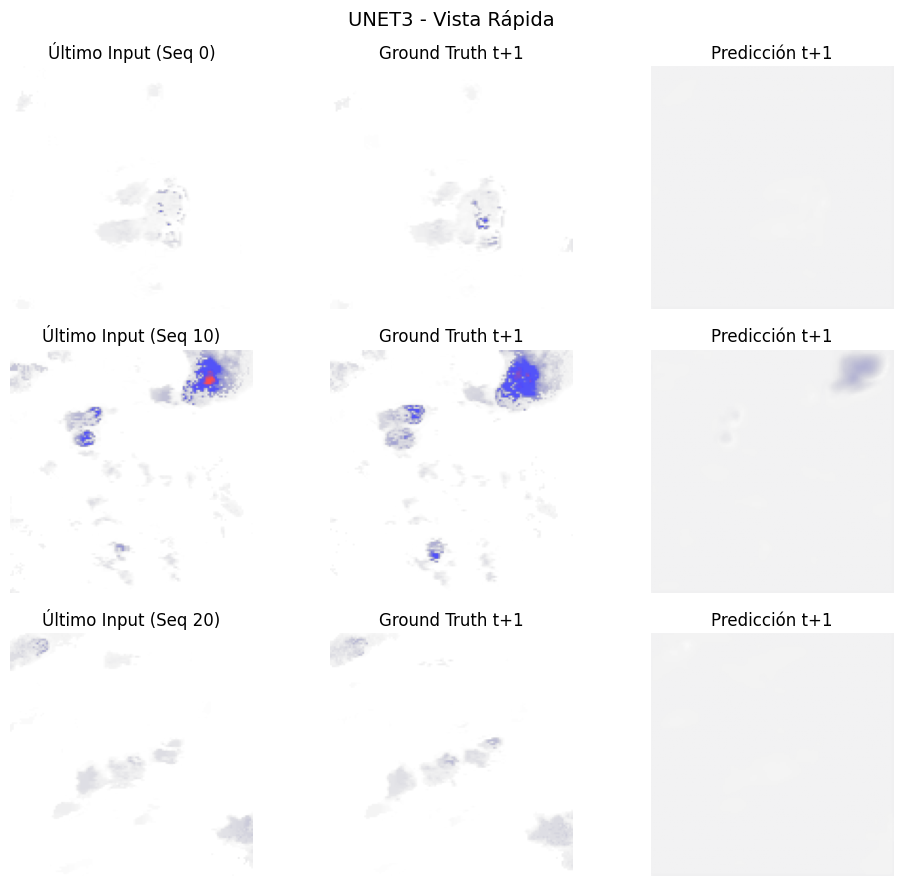

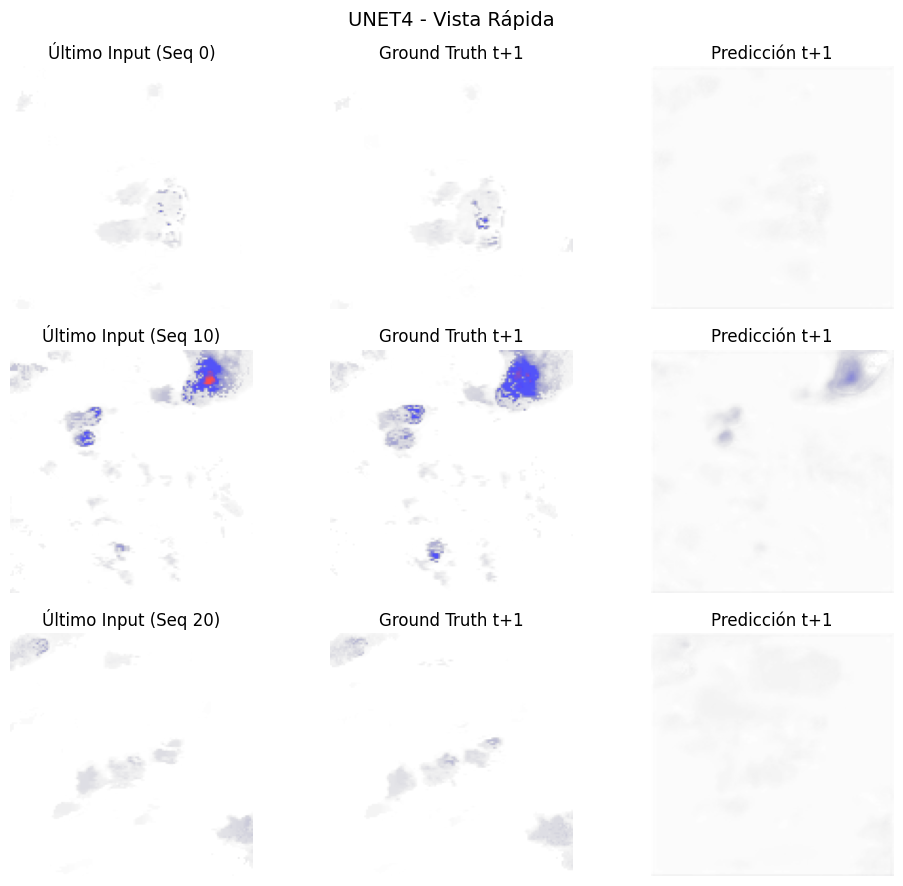

In [25]:
# Ver estadísticas generales
print("📊 RESUMEN DE RESULTADOS")
print("=" * 50)

results = results_corrected
for model_name in results.keys():
    data = results[model_name]
    print(f"\n{model_name.upper()}:")
    print(f"  Secuencias totales: {data['inputs'].shape[0]}")
    print(f"  Métricas corregidas:")
    for metric, value in data['metrics_corrected'].items():
        if metric not in ['tp', 'fp', 'fn', 'tn']:  # Solo mostrar métricas principales
            print(f"    - {metric.upper()}: {value:.4f}")
    
    # Error promedio global
    all_errors = np.abs(data['predictions'] - data['targets'])
    print(f"  MAE global: {np.mean(all_errors):.2f}")
    print(f"  Max error: {np.max(all_errors):.2f}")
    
    # Información adicional de la tabla de contingencia
    tp = data['metrics_corrected']['tp']
    fp = data['metrics_corrected']['fp']
    fn = data['metrics_corrected']['fn']
    tn = data['metrics_corrected']['tn']
    total = tp + fp + fn + tn
    
    print(f"  Tabla de contingencia:")
    print(f"    TP: {tp:,} ({tp/total*100:.1f}%)")
    print(f"    FP: {fp:,} ({fp/total*100:.1f}%)")
    print(f"    FN: {fn:,} ({fn/total*100:.1f}%)")
    print(f"    TN: {tn:,} ({tn/total*100:.1f}%)")

# Visualizar múltiples secuencias rápidamente
def quick_view(model_name, sequences=[0, 5, 10]):
    """Vista rápida de múltiples secuencias"""
    data = results[model_name]
    n_seq = len(sequences)
    
    fig, axes = plt.subplots(n_seq, 3, figsize=(10, 3*n_seq))
    if n_seq == 1:
        axes = axes.reshape(1, -1)
    
    colors = [(0, 0, 0, 0), (0, 0, 1, 0.7), (1, 0, 0, 0.7)]
    cmap = mcolors.LinearSegmentedColormap.from_list("rain", list(zip([0, 0.5, 1], colors)))
    
    for row, seq_idx in enumerate(sequences):
        # Último input
        axes[row, 0].imshow(data['inputs'][seq_idx, -1]*1, cmap=cmap, vmin=0, vmax=100)
        axes[row, 0].set_title(f'Último Input (Seq {seq_idx})')
        axes[row, 0].axis('off')
        
        # Primer target
        axes[row, 1].imshow(data['targets'][seq_idx, 0]*1, cmap=cmap, vmin=0, vmax=100)
        axes[row, 1].set_title('Ground Truth t+1')
        axes[row, 1].axis('off')
        
        # Primera predicción
        axes[row, 2].imshow(data['predictions'][seq_idx, 0], cmap=cmap, vmin=0, vmax=100)
        axes[row, 2].set_title('Predicción t+1')
        axes[row, 2].axis('off')
    
    plt.suptitle(f'{model_name.upper()} - Vista Rápida', fontsize=14)
    plt.tight_layout()
    plt.show()

# Ver múltiples secuencias de cada modelo
for model in results.keys():
    quick_view(model, sequences=[0, 10, 20])